# Plotting for final paper

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats
sns.set_style('ticks')
sns.set_context('paper')

## Quad plot

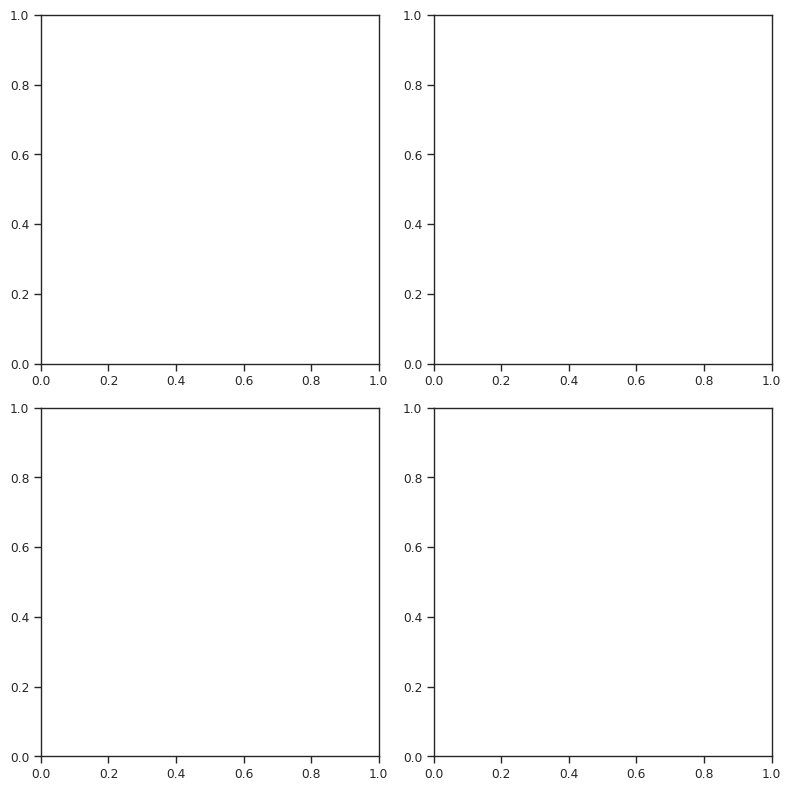

In [2]:
fig_quad, ax_quad = plt.subplots(2,2, figsize=(8,8))
fig_quad.tight_layout()

### FATCAT Pvalue comaprison

In [3]:
# get hait data
hait_data = pd.read_csv('../data/validation/structure/hait_fatcat.csv', index_col=0)

In [4]:
hait_data['exp p'] = np.exp(hait_data['p_value'])
hait_data['pass'] = hait_data['p_value'] < 0.001

In [5]:
import statsmodels.stats.proportion

In [6]:
hait_low, hait_high = statsmodels.stats.proportion.proportion_confint(hait_data['pass'].sum(), len(hait_data), method='binom_test')

In [7]:
print(f"CI For hait: {(hait_low, hait_high)}")

CI For hait: (0.986439973227603, 0.9956062201408997)


In [8]:
# get data
l2t_data = pd.read_csv('../data/validation/structure/l2t_sample_fatcat.csv')

In [9]:
l2t_data = l2t_data.rename(columns={'(query_align_cov+subject_align_cov)/2.0': 'coverage'})
l2t_data['pass'] = l2t_data['p_value'] < 0.001

In [10]:
# bin l2t by coverage
bins = [0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
l2t_data['Coverage bin'] = pd.cut(l2t_data['coverage'], bins=[0.75, 0.8, 0.85, 0.9, 0.95, 1.0])

In [11]:
low_cov_data = l2t_data[l2t_data['coverage'] <=0.8]
_ = statsmodels.stats.proportion.proportion_confint(low_cov_data['pass'].sum(), len(low_cov_data), method='binom_test')
print(f"CI for ourt data with coverage between 0.75 and 0.80: {_}")

CI for ourt data with coverage between 0.75 and 0.80: (0.9958645100917123, 0.9998042816051105)


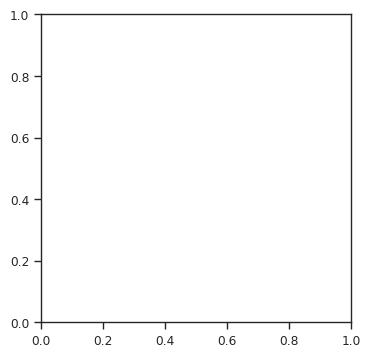

In [12]:
fig, ax = plt.subplots(figsize=(4,4))

def fatcat_plot(ax):
    g = sns.ecdfplot(data=l2t_data, x='p_value', hue='Coverage bin',ax=ax, palette='crest', lw=2)
    sns.ecdfplot(data=hait_data['p_value'].values, color='orange', label='Hait et al.', ax=ax, lw=2)
    ax.set_xscale('log')
    labels = list(l2t_data['Coverage bin'].dropna().unique())
    labels.reverse()
    labels = labels + ['Hait et al.']
    ax.legend(labels=labels, title='BLAST Coverage', loc='lower right')
    ax.set_xlabel('FATCAT P-value')
    ax.set_ylabel('Cummulative proportion')
fatcat_plot(ax_quad[1,1])

## Blast alignment comparison

In [13]:
import duckdb as ddb

In [14]:
# load hait alignment data
hait_data = pd.read_csv('../data/validation/hait_aligned_scores.csv', index_col=0)

In [15]:
# connect to out database
con = ddb.connect(database='../data/database.ddb', read_only=True)

In [16]:
our_nbs = con.execute(f"SELECT (2 * bit_score::FLOAT/(query_align_len::FLOAT + subject_align_len::FLOAT))::FLOAT FROM pairs").df().iloc[:,0].values

In [17]:
our_pid = con.execute(f"SELECT scaled_local_symmetric_percent_id FROM pairs").df().iloc[:,0].values

In [18]:
hait_data['nbs'] = hait_data.apply(lambda row: 2 * row['bit_score'] / (row['query_align_len'] + row['subject_align_len']), axis=1)

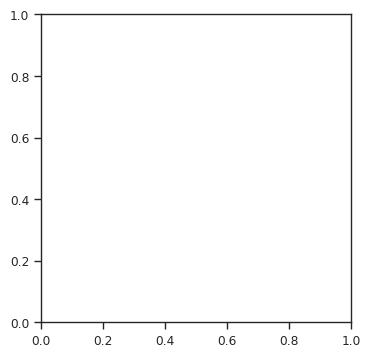

In [19]:
# add aggregate dataframe so that we can plot it
def plot_nbs(ax):
    df2_ = pd.DataFrame({'nbs': hait_data['nbs'].values, 'source': 'Hait et al.'})
    df1_ = pd.DataFrame({'nbs': our_nbs, 'source': 'learn2therm'})
    df = pd.concat([df1_, df2_], axis=0, ignore_index=True) 
    # plot
    
    sns.histplot(data=df, x='nbs', bins=25, hue='source', ax=ax, stat='probability', common_norm=False, common_bins=True, element='step')
    ax.set_xlabel("Normalized bit score")
    ax.set_ylabel('Probability')
fig, ax = plt.subplots(figsize=(4,4))
plot_nbs(ax_quad[0,0])

In [20]:
scipy.stats.ttest_ind(our_nbs, hait_data['nbs'].values, nan_policy='omit', alternative='greater')

Ttest_indResult(statistic=5.493707508900029, pvalue=1.967917619802189e-08)

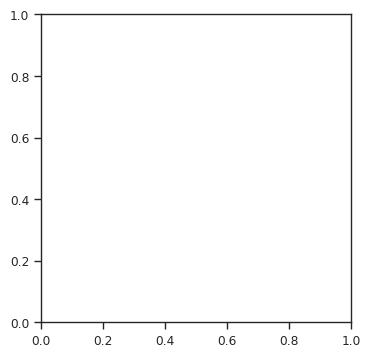

In [21]:
# add aggregate dataframe so that we can plot it
def plot_pid(ax):
    df2_ = pd.DataFrame({'scaled_local_symmetric_percent_id': hait_data['scaled_local_symmetric_percent_id'].values, 'source': 'Hait et al.'})
    df1_ = pd.DataFrame({'scaled_local_symmetric_percent_id': our_pid, 'source': 'learn2therm'})
    df = pd.concat([df1_, df2_], axis=0, ignore_index=True) 
    # plot
    
    sns.histplot(data=df, x='scaled_local_symmetric_percent_id', bins=25, hue='source', ax=ax, stat='probability', common_norm=False, common_bins=True, element='step')
    ax.set_xlabel("Symmetric %id")
    ax.set_ylabel('Probability')
fig, ax = plt.subplots(figsize=(4,4))
plot_pid(ax_quad[0,1])

In [22]:
scipy.stats.ttest_ind(our_pid, hait_data['scaled_local_symmetric_percent_id'].values, nan_policy='omit', alternative='greater')

Ttest_indResult(statistic=4.637955568485574, pvalue=1.759365209727622e-06)

In [23]:
con.close()

## HMMER compare

In [27]:
# get l2t data
con = ddb.connect('../data/database.ddb', read_only=True)
con.execute("CREATE OR REPLACE TEMP TABLE labels AS SELECT * FROM read_parquet('../data/validation/hmmer/hmmer_labels/*.parquet')")

l2t_data = con.execute("""SELECT (pairs.query_align_cov+pairs.subject_align_cov)/2.0, labels.score, labels.bool_confirmed
    FROM pairs INNER JOIN labels ON pairs.meso_pid=labels.meso_pid AND pairs.thermo_pid=labels.thermo_pid
""").df().rename(
    columns={'score': 'jaccard_score', 'bool_confirmed': 'functional', '((pairs.query_align_cov + pairs.subject_align_cov) / 2.0)': 'coverage'})

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [28]:
# get hait data
hait_data = pd.read_csv('../data/validation/hmmer/hait_scores.csv', index_col=0)[['jaccard_score', 'functional']]

# compute a t statistic
t, p = scipy.stats.ttest_ind(l2t_data['jaccard_score'], hait_data['jaccard_score'], alternative='greater',equal_var=False, nan_policy='omit')
print(f"t, p: {t}, {p} full")
t, p = scipy.stats.ttest_ind(l2t_data[l2t_data['coverage']>0.95]['jaccard_score'], hait_data['jaccard_score'], alternative='greater',equal_var=False, nan_policy='omit')
print(f"t, p: {t}, {p} 95+")



t, p: -7.571698193636757, 0.9999999999999696 full
t, p: 7.254874637111012, 3.0748202382347086e-13 95+


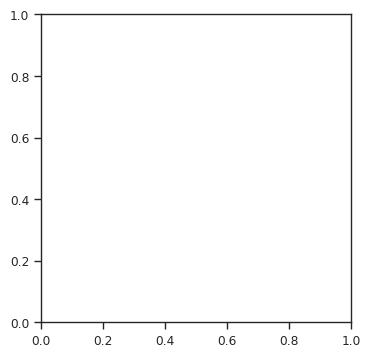

In [29]:
def plot_hmmer(ax):
    bins = list(np.linspace(0, 1, 10))
    bins.append(1.0)
    ax.hist(
        [l2t_data['jaccard_score'], l2t_data[l2t_data['coverage']>0.95]['jaccard_score'], hait_data['jaccard_score']],
        bins=10,
        alpha=1.0, 
        label=[f'learn2therm N={len(l2t_data)}',f'learn2therm 95+ N={int((l2t_data["coverage"]>0.95).sum())}', f'Hait et al. N={len(hait_data)}'],
        color=['C0', 'C2', 'C1'],
        density=True)
    ax.set_xlabel('Jaccard score of Pfam annotations')
    ax.set_ylabel('Density')
    ax.legend()
fig, ax = plt.subplots(figsize=(4,4))
plot_hmmer(ax_quad[1,0])

### save end result

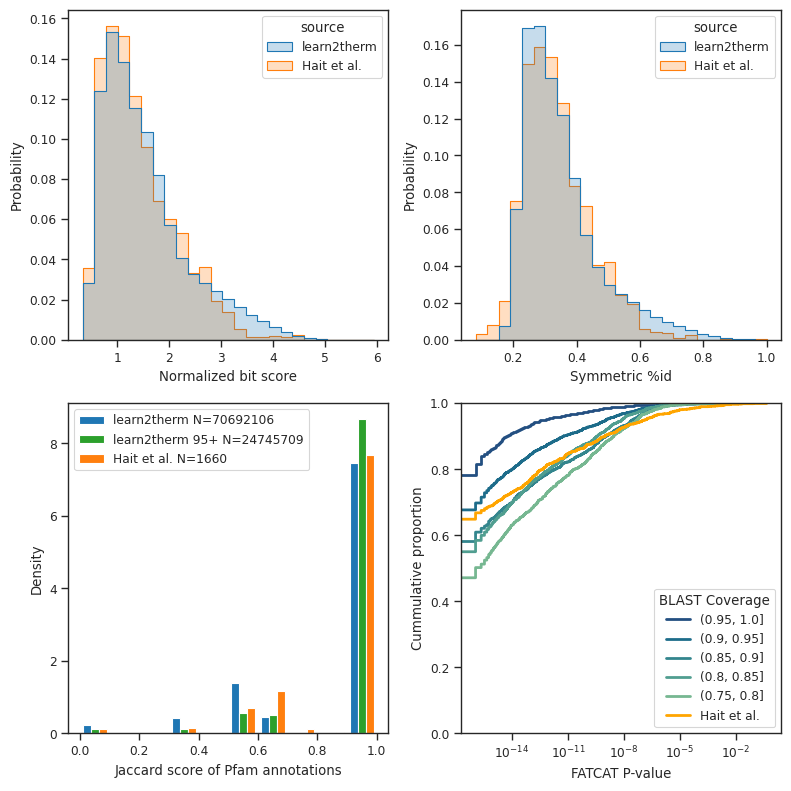

In [30]:
fig_quad.tight_layout()
fig_quad

In [31]:
fig_quad.savefig('./quad_validation.png', dpi=400, bbox_inches='tight')